## Chain Using LangGraph

In this section, we will see how we can build a simple chain using Langgraph that uses important concepts.

* How to use chat messages as our graph state
* How to use chat models in graph nodes
* How to bind tools to our LLM in chat models
* How to execute the tools call in our graph nodes.

In [1]:
from dotenv import load_dotenv 
load_dotenv()

import os

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### How to use Chat messages as our graph state

`Messages`

We can use messages which can be used to capture roles withing a conversation. LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage. These represent a message from the user, from chat model, for the chat model to instruct behaviour, and from a tool call.

Every message have these important components.
* content - content of the message
* name - Specify the name of the author
* response_metadata - optionally, a dict of metadata (e.g. often poplulated by model provider for AIMessages)

In [8]:
from langchain.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Please tell me how can I help ", name="LLMModel")]
messages.append(HumanMessage(content="I want to learn coding", name="user"))
messages.append(AIMessage(content="Which programming you want to learn?", name="LLMModel"))
messages.append(HumanMessage(content="I want to learn python programming language", name="user"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: user

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming you want to learn?
================================ Human Message =================================
Name: user

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.


In [11]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-20b")

response = llm.invoke(messages)

In [18]:
response.content

'Great choice! Python is one of the most beginner‑friendly languages, yet powerful enough for web apps, data science, automation, AI, and more.  \nBelow is a *starter roadmap* that you can follow (or adapt) to get comfortable with Python in about 4–6\u202fweeks, assuming a few hours each week. Feel free to skip sections that you already know or dive deeper into topics that interest you.\n\n---\n\n## 1️⃣  Set Up Your Environment\n\n| Step | What to do | Why it matters |\n|------|------------|----------------|\n| 1️⃣ Install Python | Download the latest Python 3.x from [python.org](https://www.python.org/downloads/) or use a distribution like **Anaconda** (great for data science). | You need the interpreter to run code. |\n| 2️⃣ Choose an IDE / Editor | VS\u202fCode, PyCharm Community, Sublime, or even a notebook (Jupyter). | Good tooling speeds learning (auto‑complete, linting). |\n| 3️⃣ Verify | Open a terminal and run `python --version` (or `python3`). | Confirms installation. |\n| 4️

In [20]:
response.usage_metadata

{'input_tokens': 114, 'output_tokens': 1625, 'total_tokens': 1739}

### Tools

Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return an output that matches the tool's schema.

In [21]:
def add(a: int, b:int  )-> int:
    """Add a and b

    Args:
        a (int): first integer
        b (int): second integer

    Returns:
        int: Sum of two numbers
    """
    return a + b

In [ ]:
# Binding tool with llm
llm_with_tools = llm.bind_tools([add])
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2  + 2 ", name="user")]) # won't return a output, this returns a tool call

In [27]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'fc_0e03d93e-e956-4117-83b6-4dd9c802eff1',
  'type': 'tool_call'}]

#### Using messages as state


In [28]:
from pydantic import BaseModel
from langchain.messages import AnyMessage

class State(BaseModel):
    message: list[AnyMessage]

#### Reducers

Now, we have a minor problem!
As we discussed, each node will return a new value for out state key messages.
But, this new value will override the prior messages value.
As our graph runs ,we want to append messages to our messages state key.
We can use reducer functions to address this.
Reducers allow use to specify how state updates are formed.
If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.
But to append, messages, we use the pre-built add_messages reducer.
This ensures that any messages are appended to the list of existing messages.
We simply need to annotate our messages key with the add_messages reducer function to metadata.

In [30]:
from typing import Annotated
from langgraph.graph import add_messages

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

#### Reducers with add_messages

In [31]:
initial_messages = [AIMessage(content="Please tell me how can I help ", name="LLMModel")]
initial_messages.append(HumanMessage(content="I want to learn coding", name="user"))


In [32]:
ai_message = AIMessage(content="which programming you want to learn",  name="LLMModel")
ai_message

AIMessage(content='which programming you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [33]:
### Reducers add-messages is to append instead of override
add_messages(initial_messages, ai_message)

[AIMessage(content='Please tell me how can I help ', additional_kwargs={}, response_metadata={}, name='LLMModel', id='ee9873fb-cc73-4d5c-b025-77475680bf1e'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='user', id='6353401f-c169-4c1c-bf9d-5197c8a7c3b5'),
 AIMessage(content='which programming you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='9be069d4-196f-498c-80d8-81fee5682f3d')]

In [39]:
# chat bot node functionality
def llm_tool(state:State):
    return {"messages": [llm_with_tools.invoke(state.messages)]}

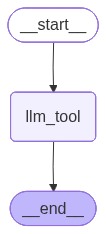

In [40]:
from IPython.display import Image, display
from langgraph.graph import START, StateGraph, END

builder = StateGraph(State)
builder.add_node("llm_tool", llm_tool)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
## invokation
messages = graph.invoke({"messages": "what is 2 plus 2?"})

for message in messages["messages"]:
    message.pretty_print() # here llm is not calling the node because there is no tool node in the graph, its showing using its internal knowledge

================================ Human Message =================================

what is 2 plus 2?
================================== Ai Message ==================================

2 plus 2 equals **4**.


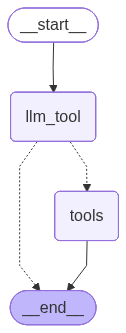

In [43]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)

# add nodes
builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools=[add]))

# add edges
builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool", 
                              tools_condition,
                              # if the latest message is a tool call, will be routed to tool otherwise routes to end
                              )

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
## invokation
messages = graph.invoke({"messages": "what is 2 plus 2?"})

for message in messages["messages"]:
    message.pretty_print() 

================================ Human Message =================================

what is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (fc_821ee45f-d8e5-47b1-b9b4-e1ba1f6f5af2)
 Call ID: fc_821ee45f-d8e5-47b1-b9b4-e1ba1f6f5af2
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [45]:
## invokation
messages = graph.invoke({"messages": "What is machine learning?"})

for message in messages["messages"]:
    message.pretty_print() 

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================

**Machine learning** is a subfield of artificial intelligence (AI) that focuses on building systems that can learn patterns and make decisions from data, without being explicitly programmed for each task.  

Key points:

1. **Learning from Data**  
   - Models are trained on large datasets, adjusting internal parameters to capture relationships between inputs and outputs.

2. **Types of Learning**  
   - **Supervised**: Uses labeled data (e.g., image classification where each image has a correct label).  
   - **Unsupervised**: Finds hidden structure in unlabeled data (e.g., clustering customers by purchasing behavior).  
   - **Reinforcement**: Learns by trial and error, receiving rewards or penalties (e.g., training a game‑playing agent).

3. **Algorithms & Techniques**  
   - Linear regression, d